In [1]:
import torch
import json
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import defaultdict
from matplotlib import pyplot

from gcd_data_manipulation import ClusterDataset
from gcd_data_manipulation import prepare_data
from shared_workspace_module import SharedWorkspaceModule

In [2]:
job_id = 6318371744
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def test_model(exp):
    checkpoint = torch.load(f'../models/gwt_models/gwt_model_{exp}.pth')

    args = checkpoint['model_args']
    print(f'last epoch: {checkpoint["epoch"]}')
    print(f'last loss: {checkpoint["loss"]}')

    with open('columns_selection.json') as f:
        columns_selection = json.load(f)

    columns_to_consider = columns_selection[args.columns_to_consider]
    num_targets = len(args.prediction_targets)

    preprocessed_data = prepare_data(f'../data/task-usage_job-ID-{job_id}_total.csv', columns_to_consider, targets=args.prediction_targets, sliding_window=args.sliding_window, aggr_type='mean')

    test_data = ClusterDataset(preprocessed_data, num_targets=num_targets, training=True, split_percentage=1)
    test_data.values.to(device)

    model = SharedWorkspaceModule(
        h_dim=args.h_dim,
        ffn_dim=args.ffn_dim,
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        dropout=args.dropout,
        shared_memory_attention=args.shared_memory_attention,
        share_vanilla_parameters=args.share_vanilla_parameters,
        use_topk=args.use_topk,
        topk=args.topk,
        mem_slots=args.mem_slots,
        num_targets=num_targets
    ).cuda()

    model.load_state_dict(checkpoint['state_dict'])

    model.eval()

    test_loader = DataLoader(test_data, batch_size=args.batch_size)
    criterion = nn.L1Loss(reduction='sum').cuda()
    result = defaultdict(list)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if num_targets == 1:
                targets = targets.reshape((targets.shape[0], 1))

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss = loss.item() / targets.shape[0]

            result['loss'].append(test_loss)

            for pred in outputs:
                result['predicted_value'].append(pred.to('cpu').numpy())

            for act in targets:
                result['actual_value'].append(act.to('cpu').numpy())

    return result

In [3]:
def eval_result(result):
    print(result['loss'])
    num_plots = len(result['actual_value'][0])
    %matplotlib widget

    # figure, axis = pyplot.subplots(num_plots)

    for i in range(num_plots):
        pyplot.clf()
        pyplot.plot([j[i] for j in result['actual_value']], '-', color='orange', label='Raw measurement')
        pyplot.plot([j[i] for j in result['predicted_value']], '--', color='blue', label='Predictions')
        pyplot.xlabel('Steps', fontsize=20)
        pyplot.ylabel('Efficiency', fontsize=20)
        pyplot.xticks(fontsize=24)
        pyplot.yticks(fontsize=24)
        pyplot.legend(fontsize=14, frameon=False)
        pyplot.tight_layout()
        pyplot.show()

last epoch: 40
last loss: 0.028766647264221165
transformer embed_dim 64
functional? False
total heads 4
head dim 16
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:8320
key:8320
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:33280
relational volatie!!!


d:\uni\bachelorarbeit\repo\polaris-ai\venv\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0.16716752733503068]


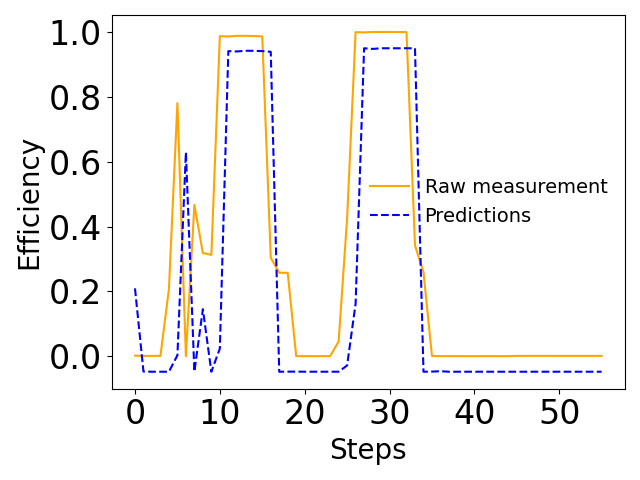

In [35]:
res_1 = test_model('exp_01')
eval_result(res_1)

last epoch: 50
last loss: 0.10393730816350095
transformer embed_dim 64
functional? False
total heads 4
head dim 16
use topk?True
topk:3
MEM SLOTS:4
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:8320
key:8320
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:33280
relational volatie!!!


d:\uni\bachelorarbeit\repo\polaris-ai\venv\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


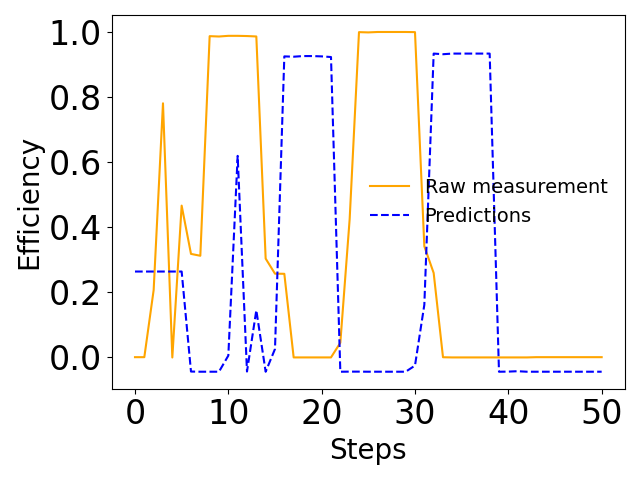

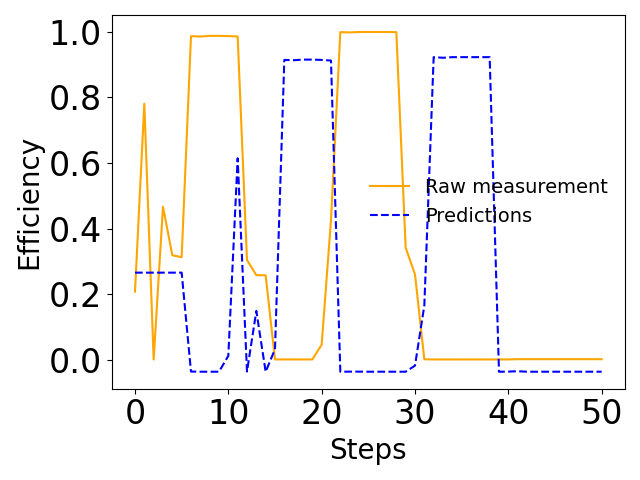

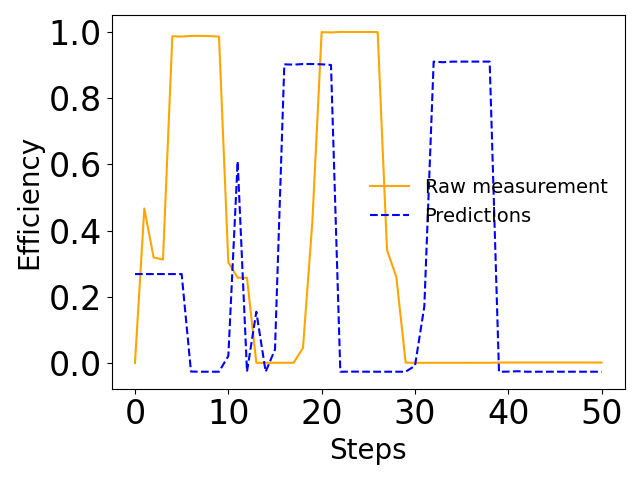

In [32]:
res_2 = test_model('exp_02')
eval_result(res_2)
# print(res_2)

last epoch: 100
last loss: 0.027329015947962478
transformer embed_dim 64
functional? False
total heads 2
head dim 32
use topk?True
topk:4
MEM SLOTS:6
Null attention:False
USING SHARED MEMORY ATTENTION +++++++++
Using gate style unit
query:4160
key:4160
value:4160
attention_mlp:4160
layernorm1:128
layernorm2:128
input_projector:4160
input projector:64
input_gate_projector:27584
memory_gate_projector:49920
relational volatie!!!


d:\uni\bachelorarbeit\repo\polaris-ai\venv\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0.14742141857481839]


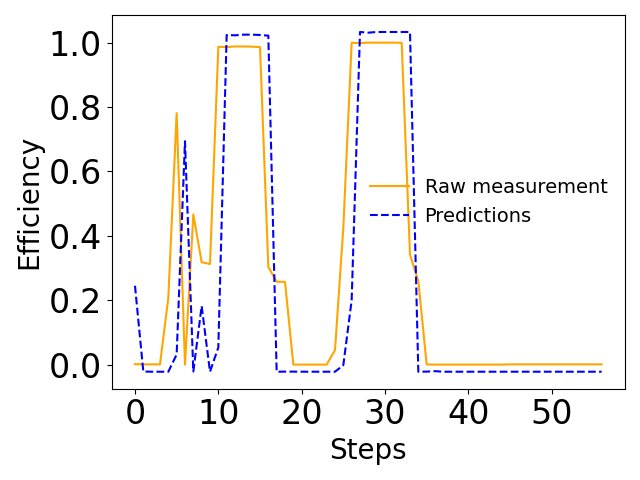

In [4]:
res_ray = test_model('ray_tune_result')
eval_result(res_ray)